# ShakespearAI: Generating Shakespearean Text with LSTM Neural Networks


In [ ]:
# Selecting Tensorflow version v2 (the command is relevant for Colab only).
# %tensorflow_version 2.x

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
#print('Keras version:', tf.keras.__version__)

Python version: 3.10.12
Tensorflow version: 2.15.0


In [ ]:
cache_dir = './tmp'
dataset_file_name = 'shakespeare.txt'
dataset_file_origin = 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt'

dataset_file_path = tf.keras.utils.get_file(
    fname=dataset_file_name,
    origin=dataset_file_origin,
    cache_dir=pathlib.Path(cache_dir).absolute()
)

print(dataset_file_path)

1115394/1115394 [==============================] - 0s 0us/step
/content/tmp/datasets/shakespeare.txt


## Analyze the dataset

In [ ]:
# Reading the database file.
text = open(dataset_file_path, mode='r').read()

print('Length of text: {} characters'.format(len(text)))

Length of text: 1115394 characters


In [ ]:
# Take a look at the first 250 characters in text.
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [ ]:
# The unique characters in the file
vocab = sorted(set(text))

print('{} unique characters'.format(len(vocab)))
print('vocab:', vocab)

65 unique characters
vocab: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## Process the dataset

In [ ]:
# Map characters to their indices in vocabulary.
char2index = {char: index for index, char in enumerate(vocab)}

print('{')
for char, _ in zip(char2index, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2index[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '$' :   3,
  '&' :   4,
  "'" :   5,
  ',' :   6,
  '-' :   7,
  '.' :   8,
  '3' :   9,
  ':' :  10,
  ';' :  11,
  '?' :  12,
  'A' :  13,
  'B' :  14,
  'C' :  15,
  'D' :  16,
  'E' :  17,
  'F' :  18,
  'G' :  19,
  ...
}


In [ ]:
# Map character indices to characters from vacabulary.
index2char = np.array(vocab)
print(index2char)

['\n' ' ' '!' '$' '&' "'" ',' '-' '.' '3' ':' ';' '?' 'A' 'B' 'C' 'D' 'E'
 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W'
 'X' 'Y' 'Z' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o'
 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [ ]:
# Convert chars in text to indices.
text_as_int = np.array([char2index[char] for char in text])

print('text_as_int length: {}'.format(len(text_as_int)))
print('{} --> {}'.format(repr(text[:15]), repr(text_as_int[:15])))

text_as_int length: 1115394
'First Citizen:\n' --> array([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0])


## Create training sequences

In [ ]:
# The maximum length sentence we want for a single input in characters.
sequence_length = 100
examples_per_epoch = len(text) // (sequence_length + 1)

print('examples_per_epoch:', examples_per_epoch)

examples_per_epoch: 11043


In [ ]:
# Create training dataset.
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for char in char_dataset.take(5):
    print(index2char[char.numpy()])

F
i
r
s
t


In [ ]:
# Generate batched sequences out of the char_dataset.
sequences = char_dataset.batch(sequence_length + 1, drop_remainder=True)

# Sequences size is the same as examples_per_epoch.
print('Sequences count: {}'.format(len(list(sequences.as_numpy_iterator()))));
print()

# Sequences examples.
for item in sequences.take(5):
    print(repr(''.join(index2char[item.numpy()])))

Sequences count: 11043

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [ ]:
# sequences shape:
# - 11043 sequences
# - Each sequence of length 101
#
#
#    101     101          101
# [(.....) (.....) ...  (.....)]
#
# <---------- 11043 ----------->

For each sequence, duplicate and shift it to form the input and target text. For example, say `sequence_length` is `4` and our text is `Hello`. The input sequence would be `Hell`, and the target sequence `ello`.

In [ ]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

In [ ]:
dataset = sequences.map(split_input_target)

# Dataset size is the same as examples_per_epoch.
# But each element of a sequence is now has length of `sequence_length`
# and not `sequence_length + 1`.
print('dataset size: {}'.format(len(list(dataset.as_numpy_iterator()))))

dataset size: 11043


In [ ]:
for input_example, target_example in dataset.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()
    print('Input:', repr(''.join(index2char[input_example.numpy()])))
    print('Target:', repr(''.join(index2char[target_example.numpy()])))

Input sequence size: 100
Target sequence size: 100

Input: 'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: 'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [ ]:
# dataset shape:
# - 11043 sequences
# - Each sequence is a tuple of 2 sub-sequences of length 100 (input_text and target_text)
#
#
#    100       100           100
# /(.....)\ /(.....)\ ... /(.....)\  <-- input_text
# \(.....)/ \(.....)/     \(.....)/  <-- target_text
#
# <----------- 11043 ------------->

Each index of these vectors are processed as one time step. For the input at time step 0, the model receives the index for "F" and trys to predict the index for "i" as the next character. At the next timestep, it does the same thing but the RNN considers the previous step context in addition to the current input character.

In [ ]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print('Step {:2d}'.format(i))
    print('  input: {} ({:s})'.format(input_idx, repr(index2char[input_idx])))
    print('  expected output: {} ({:s})'.format(target_idx, repr(index2char[target_idx])))

Step  0
  input: 18 ('F')
  expected output: 47 ('i')
Step  1
  input: 47 ('i')
  expected output: 56 ('r')
Step  2
  input: 56 ('r')
  expected output: 57 ('s')
Step  3
  input: 57 ('s')
  expected output: 58 ('t')
Step  4
  input: 58 ('t')
  expected output: 1 (' ')


In [ ]:
# Batch size.
BATCH_SIZE = 64

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<_BatchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

In [ ]:
print('Batched dataset size: {}'.format(len(list(dataset.as_numpy_iterator()))))

Batched dataset size: 172


In [ ]:
for input_text, target_text in dataset.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[ 1 57 43 ... 56 57 58]
 [ 1 58 53 ... 56 50 42]
 [58 43 50 ... 56  1 51]
 ...
 [50  1 57 ... 43  1 39]
 [52 57 58 ... 53 44  1]
 [46 47 51 ...  1 40 43]], shape=(64, 100), dtype=int64)

1st batch: target_text: tf.Tensor(
[[57 43 43 ... 57 58  1]
 [58 53  1 ... 50 42  8]
 [43 50 50 ...  1 51 63]
 ...
 [ 1 57 58 ...  1 39 50]
 [57 58 56 ... 44  1 46]
 [47 51  1 ... 40 43  1]], shape=(64, 100), dtype=int64)


In [ ]:
# dataset shape:
# - 172 batches
# - 64 sequences per batch
# - Each sequence is a tuple of 2 sub-sequences of length 100 (input_text and target_text)
#
#
#     100       100           100             100       100           100
# |/(.....)\ /(.....)\ ... /(.....)\| ... |/(.....)\ /(.....)\ ... /(.....)\|  <-- input_text
# |\(.....)/ \(.....)/     \(.....)/| ... |\(.....)/ \(.....)/     \(.....)/|  <-- target_text
#
# <------------- 64 ---------------->     <------------- 64 ---------------->
#
# <--------------------------------- 172 ----------------------------------->

In [ ]:
# Let's do a quick detour and see how Embeding layer works.
# It takes several char indices sequences (batch) as an input.
# It encodes every character of every sequence to a vector of tmp_embeding_size length.
tmp_vocab_size = 10
tmp_embeding_size = 5
tmp_input_length = 8
tmp_batch_size = 2

tmp_model = tf.keras.models.Sequential()
tmp_model.add(tf.keras.layers.Embedding(
  input_dim=tmp_vocab_size,
  output_dim=tmp_embeding_size,
  input_length=tmp_input_length
))
# The model will take as input an integer matrix of size (batch, input_length).
# The largest integer (i.e. word index) in the input should be no larger than 9 (tmp_vocab_size).
# Now model.output_shape == (None, 10, 64), where None is the batch dimension.
tmp_input_array = np.random.randint(
  low=0,
  high=tmp_vocab_size,
  size=(tmp_batch_size, tmp_input_length)
)
tmp_model.compile('rmsprop', 'mse')
tmp_output_array = tmp_model.predict(tmp_input_array)

print('tmp_input_array shape:', tmp_input_array.shape)
print('tmp_input_array:')
print(tmp_input_array)
print()
print('tmp_output_array shape:', tmp_output_array.shape)
print('tmp_output_array:')
print(tmp_output_array)

1/1 [==============================] - 0s 63ms/step
tmp_input_array shape: (2, 8)
tmp_input_array:
[[8 3 6 2 6 9 8 1]
 [6 8 0 7 5 1 6 4]]

tmp_output_array shape: (2, 8, 5)
tmp_output_array:
[[[-0.03257177 -0.03217425 -0.02686728 -0.02501801 -0.03126206]
  [-0.03753127 -0.00142755  0.0116485   0.02486709  0.01870188]
  [-0.01175161 -0.03787459  0.01203793  0.0444162  -0.01356381]
  [-0.04079773 -0.00561372 -0.0395715  -0.03764707 -0.03383026]
  [-0.01175161 -0.03787459  0.01203793  0.0444162  -0.01356381]
  [ 0.03816978  0.02030864 -0.02940527  0.02093622  0.00437369]
  [-0.03257177 -0.03217425 -0.02686728 -0.02501801 -0.03126206]
  [ 0.04472369 -0.01893893 -0.03958858  0.02353397  0.02101963]]

 [[-0.01175161 -0.03787459  0.01203793  0.0444162  -0.01356381]
  [-0.03257177 -0.03217425 -0.02686728 -0.02501801 -0.03126206]
  [ 0.02613337  0.0248947   0.02847043  0.01872287 -0.03068615]
  [-0.00288795 -0.04849866  0.00260564 -0.02980711  0.026671  ]
  [-0.02857152  0.03761658 -0.03617198 

In [ ]:
# Length of the vocabulary in chars.
vocab_size = len(vocab)

# The embedding dimension.
embedding_dim = 256

# Number of RNN units.
rnn_units = 1024

In [ ]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
      units=rnn_units,
      return_sequences=True,
      stateful=True,
      recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))

    return model

In [ ]:
model = build_model(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (64, None, 256)           16640     
                                                                 
 lstm_2 (LSTM)               (64, None, 1024)          5246976   
                                                                 
 dense_2 (Dense)             (64, None, 65)            66625     
                                                                 
Total params: 5330241 (20.33 MB)
Trainable params: 5330241 (20.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


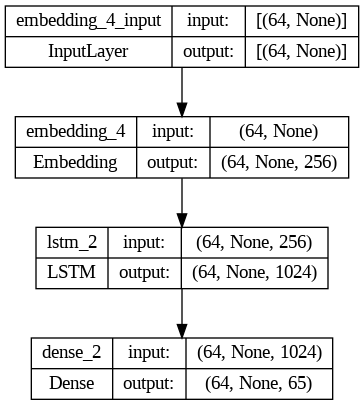

In [ ]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

## Try the model

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")


(64, 100, 65) # (batch_size, sequence_length, vocab_size)


To get actual predictions from the model we need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

In [ ]:
print('Prediction for the 1st letter of the batch 1st sequense:')
print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the batch 1st sequense:
tf.Tensor(
[-7.6669641e-04  7.9291593e-04 -1.1729788e-03 -9.9864160e-04
 -4.4355225e-03 -3.3488909e-03  4.3802299e-03 -2.5919287e-03
  3.6530152e-03 -2.0309675e-03 -9.8053046e-05 -1.3692812e-03
 -1.3837118e-03 -1.3538881e-03 -1.5216910e-03  5.4035550e-03
 -7.9655368e-04 -4.3249186e-03  9.0421201e-04  1.6895588e-04
 -1.6096220e-03  1.2634846e-03  2.0171597e-03  9.6815289e-05
  3.5917857e-03 -1.2590059e-03  3.5282103e-03 -3.5128300e-03
 -1.8994340e-03  1.0389064e-03  1.7952831e-03  3.1177946e-03
  3.4258699e-03 -4.4107102e-03  2.9226241e-03 -5.3197215e-04
  1.3521335e-03 -4.6822005e-03  9.4971694e-03  6.4896178e-03
 -2.7934040e-03 -4.9372213e-03  1.5592754e-03  2.1247400e-03
  8.3771432e-03 -4.7075506e-03  7.3184697e-03 -7.6580897e-04
 -8.8230940e-04 -1.6935484e-03 -7.2018045e-04 -1.3341815e-03
 -3.9298199e-03 -4.6592602e-03 -5.4474408e-04  1.9385528e-03
 -2.0884334e-03  6.4407277e-04 -2.8360726e-03 -4.7818511e-03
 -9.4040763e-05 -

In [ ]:
# Quick overview of how tf.random.categorical() works.

# logits is 2-D Tensor with shape [batch_size, num_classes].
# Each slice [i, :] represents the unnormalized log-probabilities for all classes.
# In the example below we say that the probability for class "0" is low but the
# probability for class "2" is much higher.
tmp_logits = [
  [-0.95, 0, 0.95],
];

# Let's generate 5 samples. Each sample is a class index. Class probabilities
# are being taken into account (we expect to see more samples of class "2").
tmp_samples = tf.random.categorical(
    logits=tmp_logits,
    num_samples=5
)

print(tmp_samples)

tf.Tensor([[0 1 1 2 0]], shape=(1, 5), dtype=int64)


In [ ]:
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],
    num_samples=1
)

sampled_indices.shape

TensorShape([100, 1])

In [ ]:
sampled_indices = tf.squeeze(
    input=sampled_indices,
    axis=-1
).numpy()

sampled_indices.shape

(100,)

In [ ]:
sampled_indices

array([13, 12, 53, 62, 21, 40, 52, 19, 34, 42, 30, 30, 63, 34, 42, 40, 27,
       31, 18,  5,  9, 34, 12, 38, 59, 29, 41, 53, 58, 13, 36,  3, 52, 49,
       62, 48, 23, 51,  7, 58, 30, 35,  2, 20, 40, 45, 16, 26,  0, 30, 21,
       54, 51, 28, 58, 36, 36, 29, 32, 13, 28,  7, 58, 26, 51, 52, 29, 40,
       64, 33, 64, 22, 32, 59,  3,  2, 56, 38,  5, 29, 32, 48,  0, 49, 64,
       19, 46, 30, 21, 10,  4, 34, 14, 37, 61, 59, 32,  3, 18, 42])

In [ ]:
print('Input:\n', repr(''.join(index2char[input_example_batch[0]])))
print()
print('Next char prediction:\n', repr(''.join(index2char[sampled_indices])))

Input:
 "urage and in judgment\nThat they'll take no offence at our abuse.\n\nKING EDWARD IV:\nSuppose they take "

Next char prediction:
 "A?oxIbnGVdRRyVdbOSF'3V?ZuQcotAX$nkxjKm-tRW!HbgDN\nRIpmPtXXQTAP-tNmnQbzUzJTu$!rZ'QTj\nkzGhRI:&VBYwuT$Fd"


In [ ]:
for i, (input_idx, sample_idx) in enumerate(zip(input_example_batch[0][:5], sampled_indices[:5])):
    print('Prediction {:2d}'.format(i))
    print('  input: {} ({:s})'.format(input_idx, repr(index2char[input_idx])))
    print('  next predicted: {} ({:s})'.format(target_idx, repr(index2char[sample_idx])))

Prediction  0
  input: 59 ('u')
  next predicted: 1 ('A')
Prediction  1
  input: 56 ('r')
  next predicted: 1 ('?')
Prediction  2
  input: 39 ('a')
  next predicted: 1 ('o')
Prediction  3
  input: 45 ('g')
  next predicted: 1 ('x')
Prediction  4
  input: 43 ('e')
  next predicted: 1 ('I')


### Attach an optimizer, and a loss function

In [ ]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 65)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.174452


In [ ]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam_optimizer,
    loss=loss,
    metrics=['acc']
)

### Configure checkpoints

In [ ]:
# Directory where the checkpoints will be saved.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

### Execute the training

In [ ]:
EPOCHS=40

In [ ]:
history = model.fit(
  x=dataset,
  epochs=EPOCHS,
  callbacks=[
    checkpoint_callback
  ]
)

Epoch 1/40
172/172 [==============================] - 17s 75ms/step - loss: 2.5779 - acc: 0.2906
Epoch 2/40
172/172 [==============================] - 15s 75ms/step - loss: 1.8672 - acc: 0.4525
Epoch 3/40
172/172 [==============================] - 15s 72ms/step - loss: 1.6217 - acc: 0.5188
Epoch 4/40
172/172 [==============================] - 14s 69ms/step - loss: 1.4924 - acc: 0.5530
Epoch 5/40
172/172 [==============================] - 14s 70ms/step - loss: 1.4140 - acc: 0.5729
Epoch 6/40
172/172 [==============================] - 14s 72ms/step - loss: 1.3589 - acc: 0.5864
Epoch 7/40
172/172 [==============================] - 15s 71ms/step - loss: 1.3140 - acc: 0.5981
Epoch 8/40
172/172 [==============================] - 14s 72ms/step - loss: 1.2757 - acc: 0.6087
Epoch 9/40
172/172 [==============================] - 14s 71ms/step - loss: 1.2397 - acc: 0.6183
Epoch 10/40
172/172 [==============================] - 14s 71ms/step - loss: 1.2032 - acc: 0.6290
Epoch 11/40
172/172 [========

In [ ]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

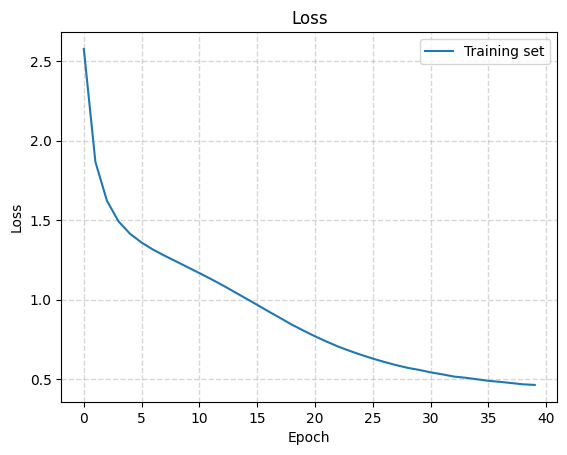

In [ ]:
render_training_history(history)

## Generate text

In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)

'tmp/checkpoints/ckpt_40'

In [ ]:
simplified_batch_size = 1

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([simplified_batch_size, None]))

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (1, None, 256)            16640     
                                                                 
 lstm_3 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dense_3 (Dense)             (1, None, 65)             66625     
                                                                 
Total params: 5330241 (20.33 MB)
Trainable params: 5330241 (20.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# num_generate
# - number of characters to generate.
#
# temperature
# - Low temperatures results in more predictable text.
# - Higher temperatures results in more surprising text.
# - Experiment to find the best setting.
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing).
    input_indices = [char2index[s] for s in start_string]
    input_indices = tf.expand_dims(input_indices, 0)

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
        predictions,
        num_samples=1
        )[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)

        text_generated.append(index2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [ ]:
# Generate the text with default temperature (1.0).
print(generate_text(model, start_string=u"ROMEO: "))

ROMEO: my comfort at my life,
My signorance have access two of his
most father, and S:
Ele-heart's death--
Sufficeth the king and England's peg,
That I, since is here told thee pardon or other way
To this should call forthwith. What say you to not?

AUTOLYCUS:
Now, had I not the day that breathe turns of my man,
'When thou wert down, safely, and my good speed speed;
In all the gracious yea warnow'
Which sixteen his driming arm up, and that we heard aside.

ADORSSS:
What, ho! Was ever father's griefs, the Earl of Wiltshire
Shall have the current, but to rave his relievent.
What, have I pinch'd you, Signior Gremio: If I

DUKE VINCENTIO:
The woman's valour of a smolting land.
Most strength and daughters, on the heel
Of the sins of his liberty or ere, like so please
Blown with their uncle, that the Benviod state
than queen?

PETRUCHIO:
A coward with me?

PAULINA:
It is it now, my lord.

DUKE VINCENTIO:
I know here he would have weigh'd the grace, 'Ke, no an artifuld,
And see it is am sure 

In [ ]:
# Generate the text with higher temperature to get more unexpected results.
print(generate_text(model, start_string=u"ROMEO: ", temperature=1.5))

ROMEO: faint George from this fool 'choo;' the
herd our geveralty of Vincentio. Heaven keep up away;
Him will go sleep thee: 'tis no time to play with men
Like to his father, but
I dare make good and hope.

GREMIO:
No roges man that did not perused
Give signal to the prince: thy humble walk,
mark'd facel that
which contents from fashion, but
Like Roman: Tuff;
the crown,
Whise wouldst seld--we,
Vight runame, God, I tell you
Where that means may wed your mistress s;
Broke:
Bappily, my heart to wail but storelok pen.
Where'er Your wrong?

KING RICHARD II:
No assura doth not give injustice with his virtue from
the miduade: they kepinking Henry's face,
How can you learn from some other lays fain the best;
And when I seek will play to her:
She may, my doubt,--

First Officer:
Ith good night than gilty haste
There'e at honesty. Sir, your voices Kind Northumber,
What have I come, you might Surrance to my anvish word:
The sleepy cry our humour from this?
No;
I must have liege.

KING RICHARD II:

## Save the model

In [ ]:
model_name = 'text_generation_shakespeare_rnn.h5'
model.save(model_name, save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
def perplexity(text, model):
    # Converting text to integers
    text_as_int = np.array([char2index[char] for char in text])

    # Converting to dataset
    input_eval = tf.expand_dims(text_as_int[:-1], 0)
    target = text_as_int[1:]

    # Empty string to store results
    text_generated = []

    # Model reset
    model.reset_states()

    # Get predictions
    predictions = model(input_eval)
    predictions = tf.squeeze(predictions, 0)

    # Compute perplexity
    cross_entropy = tf.keras.losses.sparse_categorical_crossentropy(target, predictions, from_logits=True)
    perplexity = 2 ** (np.mean(cross_entropy))

    return perplexity

# Generate some text using your model
generated_text = generate_text(model, start_string=u"ROMEO: ", num_generate=1000)

# Evaluate the perplexity of the generated text
perplexity_score = perplexity(generated_text, model)
print("Perplexity of the generated text:", perplexity_score)


Perplexity of the generated text: 1.6049540048637365


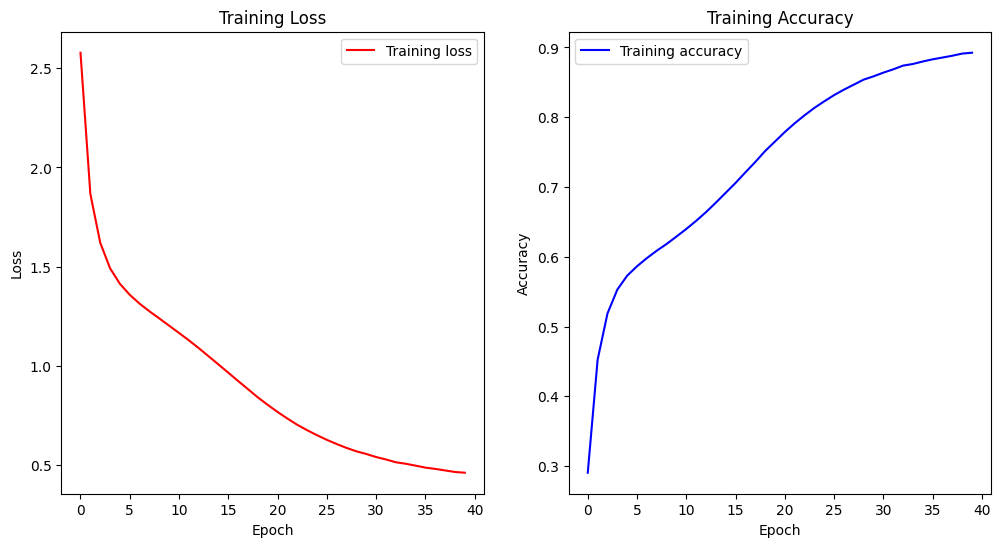

In [ ]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    accuracy = training_history.history['acc']

    epochs = range(len(loss))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'b', label='Training accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

render_training_history(history)


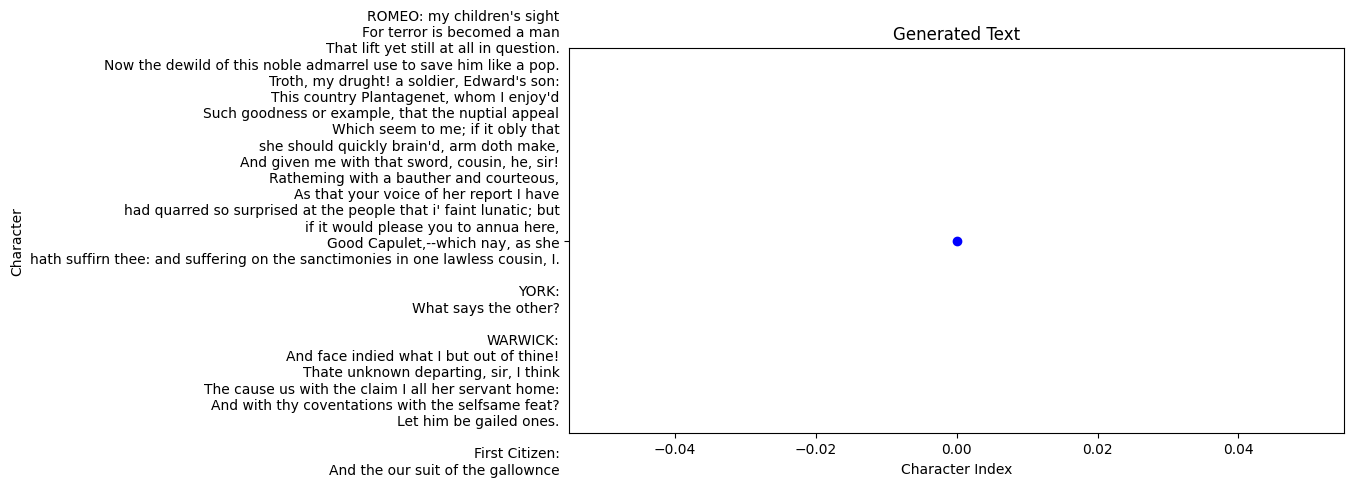

In [ ]:
import matplotlib.pyplot as plt

def plot_generated_text(text):
    plt.figure(figsize=(10, 5))
    plt.plot(text, marker='o', linestyle='-', color='b')
    plt.title('Generated Text')
    plt.xlabel('Character Index')
    plt.ylabel('Character')
    plt.show()

generated_text = generate_text(model, start_string=u"ROMEO: ")
plot_generated_text(generated_text)


In [ ]:
def generate_text(model, start_string, num_generate=1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)
    # Converting our start string to numbers (vectorizing).
    input_indices = [char2index[s] for s in start_string]
    input_indices = tf.expand_dims(input_indices, 0)

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
            predictions,
            num_samples=1
        )[-1, 0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)

        text_generated.append(index2char[predicted_id])

    return (start_string + ''.join(text_generated))


In [ ]:
# Generate the text with default temperature (1.0).
print(generate_text(model, start_string=u"ROMEO: "))



ROMEO: VINCENTIO:
Away filly Citizen:
Why 'love's like an asse this tireful shop,
As may be holy as secret musty powerful wind.

HORTENSIO:
Who, ay she be contented? The gone I have,
Though thou wilt say 's, to yours:
Thither away; let's hear a little present
My very nature best becomes my greeting:
it is too dear a scarce, to tunor so baddle; wherein ed them
not from death, with that were they were an age and virtuous
Marchastisement will cast upon thee, mark me.

HASTINGS:
Good faith, I'll keep him take our letters that three mairs ght whose suit deep as thou canst ducky your talk,
And with thy scouts: himself! when did scarcel of my free,
And will once in sacrament with I speak: do not say, here comes she say,
Both festing Warwick stand you from deserving
At Cheery Pompey, guardly or better than our pawer.
Lord Angelo is calm, and lose not what my teeth, my lord.

KING HENRY VI:
I will accop a VINCENTIO:
Let me swear soft love in reverend from the French to play me: this is a measur

In [ ]:
# Generate the text with higher temperature to get more unexpected results.
print(generate_text(model, start_string=u"ROMEO: ", temperature=1.5))

ROMEO: he's dead,' testymat:
Under war shall meet again,
To put abstly suit at Duchmonyour reason
With all his lanks and scars that your steed gross,
Laugh'd with me; having not so good night on Tower.

ARCHBISHOPan:
What parmoor is call'd E report of love.
Who sensibly outward Malian excepts you, sir, me;
For they say and no less creation gentlewomenger, though I have:
I oming his heel, but base merriquich i' the morning
And give it iracting whistly.
More light, throw valour'st knightly Kate?
You are the sur.

MENENIUS:
One i' the neck.

COMINIUS:
Well, on travomious.
You must toll us but upon e
would sir, if ever throat hath kept y time that he hath some power, knich in a fear
And none can take that profit
dry sovereign. But juck
bring twive water: though
'vike no man not remove: I had rather die.

ISABELLA:
In such a command.

ALONSO:
Sons, u, with.

Third Citizen:
We are accompatained with t, theysat Was worth the dine! wishing clock?
Away those
save but justified. How you pursuada

In [ ]:
pip install nltk